# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [1]:
!pip install ipython-autotime
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 9.2 MB/s eta 0:00:01


In [112]:
import warnings
warnings.filterwarnings('ignore')

time: 524 µs (started: 2021-04-28 11:05:38 +00:00)


In [113]:
%matplotlib inline
%load_ext autotime

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from utils import MultipleTimeSeriesCV, format_time

sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice
YEAR = 252

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.96 ms (started: 2021-04-28 11:05:39 +00:00)


In [114]:
### set path
import os
from pathlib import Path
path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'
if not path_result.exists():
    path_result.mkdir()

time: 948 µs (started: 2021-04-28 11:05:41 +00:00)


## Get Data

See the notebook [japanese_equity_features](03_japanese_equity_features.ipynb) in this directory for data preparation.

In [ ]:
!gs cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip
!unzip stooq_jp_data.zip

In [115]:
data = (pd.read_csv(path_data / 'stooq_jp_equities.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])      
       )
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2303568 non-null  float64
 1   ret_rel_perc_1   2303568 non-null  float64
 2   ret_5            2299804 non-null  float64
 3   ret_rel_perc_5   2299804 non-null  float64
 4   ret_10           2295099 non-null  float64
 5   ret_rel_perc_10  2295099 non-null  float64
 6   ret_21           2284748 non-null  float64
 7   ret_rel_perc_21  2284748 non-null  float64
 8   ret_63           2245226 non-null  float64
 9   ret_rel_perc_63  2245226 non-null  float64
 10  PPO              2280984 non-null  float64
 11  NATR             2291335 non-null  float64
 12  RSI              2291335 non-null  float64
 13  bbl              2300745 non-null  float64
 14  bbu              2300745 non-nul

We start with 941 tickers.

In [116]:
len(data.index.unique('ticker'))

941

time: 25.6 ms (started: 2021-04-28 11:06:50 +00:00)


### Select universe of 250 most-liquid stocks

We rank the stocks by their daily average dollar volume and select those with the 250 lowest average ranks and thus highest average volumes for the 2010-2017 period.

In [117]:
prices = (pd.read_csv(path_data / 'stooq_jp_tse_stocks_prices.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])    
          .loc[idx[:, '2010': '2017'], :]
         )

time: 13.8 s (started: 2021-04-28 11:07:07 +00:00)


In [118]:
dollar_vol = prices.close.mul(prices.volume)
dollar_vol_rank = dollar_vol.groupby(level='date').rank(ascending=False)
universe = dollar_vol_rank.groupby(level='ticker').mean().nsmallest(250).index

time: 3.61 s (started: 2021-04-28 11:07:21 +00:00)


## MultipleTimeSeriesCV

For each fold, the train and test periods are separated by a `lookahead` number of periods and thus do not overlap:

In [119]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.groupby(level="ticker").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    if i == 3:
        break

Training: 2017-10-24-2019-11-25  (508 days) | Test: 2019-12-02-2019-12-30 (21 days)
Training: 2017-09-22-2019-10-24  (508 days) | Test: 2019-10-31-2019-11-29 (21 days)
Training: 2017-08-23-2019-09-20  (508 days) | Test: 2019-09-30-2019-10-30 (21 days)
Training: 2017-07-24-2019-08-21  (508 days) | Test: 2019-08-28-2019-09-27 (21 days)
time: 8.05 s (started: 2021-04-28 11:07:45 +00:00)


## Model Selection: Time Period and Horizon

For the model selection step, we restrict training and validation sets to the 2010-2017 period.

In [120]:
cv_data = data.loc[idx[universe, :'2017'], :]
tickers = cv_data.index.unique('ticker')
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 420082 entries, ('7203.JP', Timestamp('2010-01-04 00:00:00')) to ('4021.JP', Timestamp('2017-12-29 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ret_1            419868 non-null  float64
 1   ret_rel_perc_1   419868 non-null  float64
 2   ret_5            419012 non-null  float64
 3   ret_rel_perc_5   419012 non-null  float64
 4   ret_10           417942 non-null  float64
 5   ret_rel_perc_10  417942 non-null  float64
 6   ret_21           415588 non-null  float64
 7   ret_rel_perc_21  415588 non-null  float64
 8   ret_63           406600 non-null  float64
 9   ret_rel_perc_63  406600 non-null  float64
 10  PPO              414732 non-null  float64
 11  NATR             417086 non-null  float64
 12  RSI              417086 non-null  float64
 13  bbl              419226 non-null  float64
 14  bbu              419226 non-null  float64
 15  we

Persist the data to save some time when running another experiment:

In [11]:
cv_data.to_csv(path_data / 'stooq_jp_equities_cv.csv')
!zip -u stooq_jp_data.zip data/stooq_jp_equities_cv.csv

  adding: data/stooq_jp_equities_cv.csv (deflated 65%)
time: 24.5 s (started: 2021-04-28 01:39:03 +00:00)


We're picking prediction horizons of 1, 5, 10 and 21 days:

In [121]:
lookaheads = [1, 5, 10, 21]

time: 523 µs (started: 2021-04-28 11:08:46 +00:00)


## Baseline: Linear Regression

Since it's quick to run and quite informative, we generate linear regression baseline predictions. See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [13]:
lr = LinearRegression(n_jobs=-1)

time: 440 µs (started: 2021-04-28 01:40:01 +00:00)


In [14]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

time: 11.8 ms (started: 2021-04-28 01:40:07 +00:00)


### CV Parameters

We set five different training lengths from 3 months to 5 years, and two test periods as follows:

In [18]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_length = 2 * YEAR

time: 584 µs (started: 2021-04-28 01:42:02 +00:00)


Since linear regression has no hyperparameters, our CV parameters are the cartesian product of prediction horizon and train/test period lengths:

In [16]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
len(test_params)

40

time: 3.04 ms (started: 2021-04-28 01:40:46 +00:00)


Now we iterate over these parameters and train/validate the linear regression model while capturing the information coefficient of the model predictions, measure both on a daily basis and for each complete fold:

In [19]:
lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(val_length / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 40/40 [04:21<00:00,  6.55s/it]

time: 4min 21s (started: 2021-04-28 01:42:05 +00:00)


In [20]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB
time: 14.4 ms (started: 2021-04-28 01:48:32 +00:00)


### Information Coefficient distribution by Lookahead

Convert the data to long `seaborn`-friendly format:

In [21]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     80 non-null     int64  
 1   Train Length  80 non-null     int64  
 2   Test Length   80 non-null     int64  
 3   IC            80 non-null     float64
 4   Measure       80 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB
time: 18.1 ms (started: 2021-04-28 01:48:49 +00:00)


Plot both IC measures for the various CV parameters:

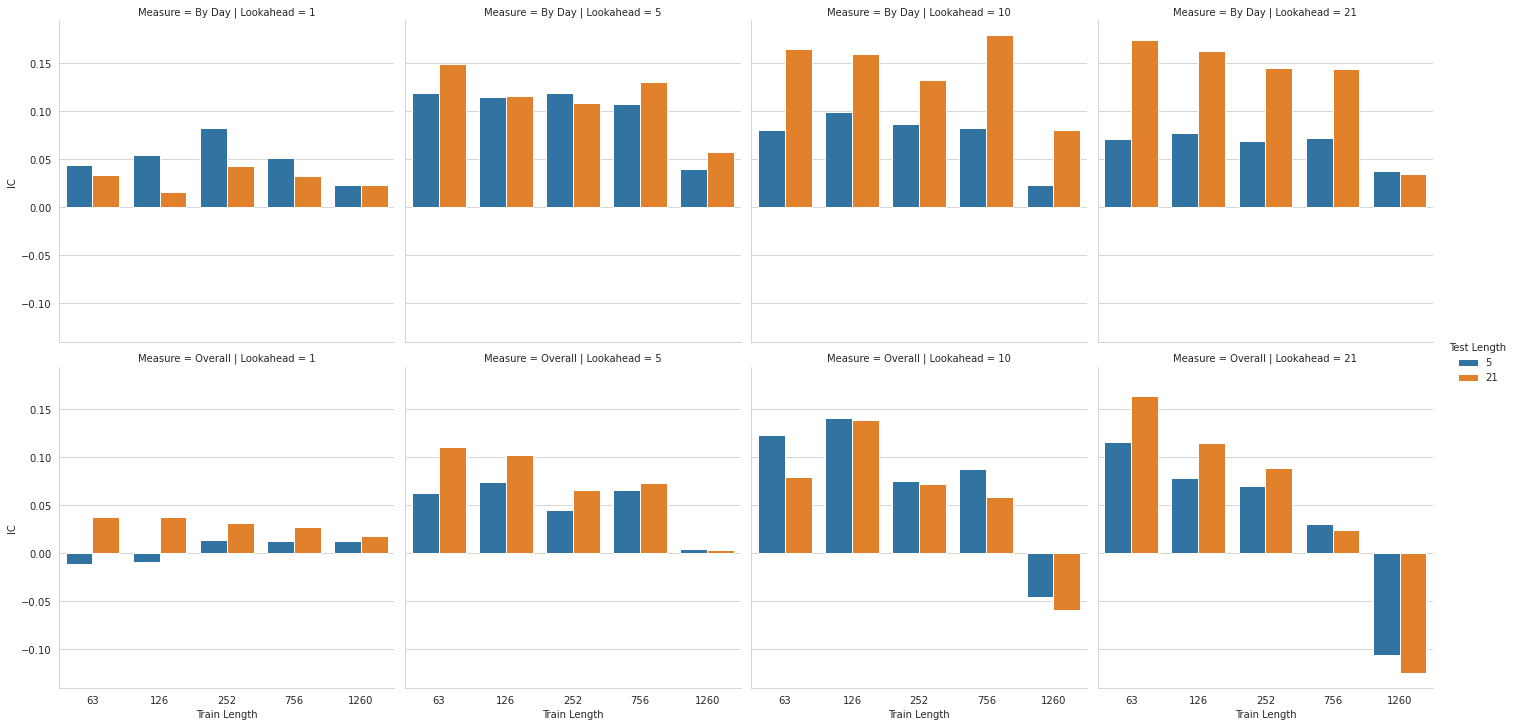

time: 1.9 s (started: 2021-04-28 01:48:55 +00:00)


In [22]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

Compare the distributions of each IC metric for the different prediction horizons:

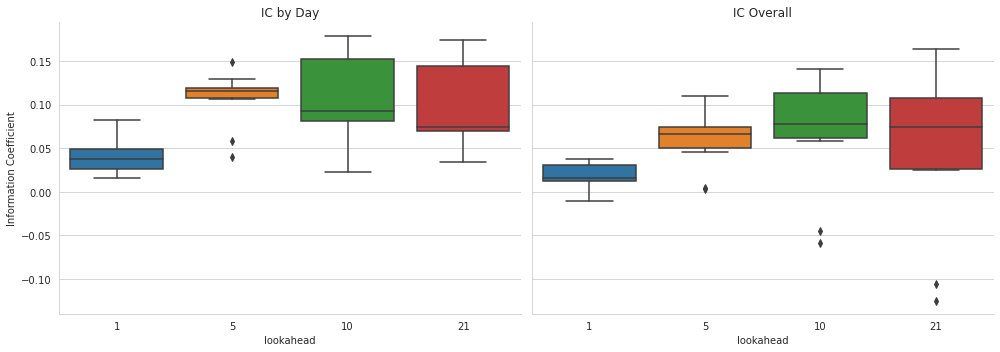

time: 442 ms (started: 2021-04-28 01:49:27 +00:00)


In [23]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

### Best Train/Test Period Lengths

Show the best train/test period settings for the four prediction horizons:

In [24]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
9,1,63,21,0.033615,0.037822
7,1,126,21,0.015814,0.037618
5,1,252,21,0.042732,0.031847
19,5,63,21,0.148540,0.110126
17,5,126,21,0.115812,0.101829
16,5,126,5,0.114283,0.074268
26,10,126,5,0.098941,0.140911
27,10,126,21,0.158797,0.138540
28,10,63,5,0.080264,0.122674
39,21,63,21,0.174340,0.163393


time: 29.3 ms (started: 2021-04-28 01:49:36 +00:00)


In [26]:
lr_metrics.to_csv(path_result / 'lin_reg_performance.csv', index=False)
!zip stooq_jp_result.zip result/lin_reg_performance.csv

  adding: result/lin_reg_performance.csv (deflated 53%)
time: 138 ms (started: 2021-04-28 01:50:25 +00:00)


## LightGBM Random Forest Model Tuning

Helper function to obtain the LightGBM feature importance metrics:

In [122]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

time: 694 µs (started: 2021-04-28 11:10:11 +00:00)


LightGBM base parameter settings that are independent of hyperparameter tuning:

In [123]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 4
time: 1.32 ms (started: 2021-04-28 11:10:14 +00:00)


### Hyperparameter Options

We run this experiment with different parameters for the bagging and feature fractions that determine the degree of randomization as well as the minimum number of samples for a split to control overfitting:

In [124]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [250, 500, 1000]

time: 512 µs (started: 2021-04-28 11:10:29 +00:00)


This gives us 3x2x3=18 parameter combinations:

In [125]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

time: 3 ms (started: 2021-04-28 11:10:34 +00:00)


#### Random Sample

To limit the running time, we can randomly sample a subset of the parameter combinations (here: 50%):

In [146]:
sample_proportion = .5
#sample_proportion = .2 # testing
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 9
time: 1.84 ms (started: 2021-04-28 11:42:25 +00:00)


We tune the number of trees by evaluating a fully grown forest for various smaller sizes:

In [147]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

time: 486 µs (started: 2021-04-28 11:42:27 +00:00)


### Train/Test Period Lenghts

As above for linear regression, we define a range of train/test period length:

#### Define parameters

In [148]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_lengths = 2 * YEAR

test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

time: 665 µs (started: 2021-04-28 11:42:30 +00:00)


#### Random sample

Just as for the model parameters, we can randomly sample from the 5 x 2 = 8 training configurations (here: 50%):

In [ ]:
sample_proportion = 0.5
#sample_proportion = .2 # testing
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('lookaheads:', len(lookaheads))
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_))
print('# of run:', len(lookaheads) * len(test_params_) * len(cv_params_))

### Categorical Variables

To leverage LightGBM's ability to handle categorical variables, we need to define them; we'll also `factorize` them so they are both integer-encoded and start at zero (optional, but otherwise throws a warning) as expected by LightGBM:

In [150]:
cv_data = (pd.read_csv(path_data / 'stooq_jp_equities_cv.csv' , parse_dates=['date'])
             .set_index(['ticker','date'])
             .sort_index(level=['ticker','date'])      
          )
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    cv_data[feature] = pd.factorize(cv_data[feature], sort=True)[0]
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 420082 entries, ('1605.JP', Timestamp('2010-01-04 00:00:00')) to ('9984.JP', Timestamp('2017-12-29 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ret_1            419868 non-null  float64
 1   ret_rel_perc_1   419868 non-null  float64
 2   ret_5            419012 non-null  float64
 3   ret_rel_perc_5   419012 non-null  float64
 4   ret_10           417942 non-null  float64
 5   ret_rel_perc_10  417942 non-null  float64
 6   ret_21           415588 non-null  float64
 7   ret_rel_perc_21  415588 non-null  float64
 8   ret_63           406600 non-null  float64
 9   ret_rel_perc_63  406600 non-null  float64
 10  PPO              414732 non-null  float64
 11  NATR             417086 non-null  float64
 12  RSI              417086 non-null  float64
 13  bbl              419226 non-null  float64
 14  bbu              419226 non-null  float64
 15  we

### Run Cross-Validation

Set up some helper variabels and storage locations to faciliate the CV process and result storage:

In [151]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()
label_dict = dict(zip(lookaheads, labels))

time: 5.96 ms (started: 2021-04-28 11:43:03 +00:00)


In [152]:
ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

time: 509 µs (started: 2021-04-28 11:43:04 +00:00)


Now we take the following steps:
- we iterate over the prediction horizons and train/test period length, 
- set up the `MultipleTimeSeriesCV` accordingly
- create the binary LightGBM dataset with the appropriate target, and
- iterate over the model hyperparamters to train and validate the model while capturing the relevant performance metrics:

In [153]:
from google.cloud import storage

def upload_blob(source_file_name, 
                destination_dir='lbk/rf/', 
                bucket_name='finance_data_bucket'):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"

    destination_blob_name = destination_dir + str(source_file_name).split('/')[-1]
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

time: 738 µs (started: 2021-04-28 11:43:07 +00:00)


In [ ]:
import pickle

#for lookahead in lookaheads:
for lookahead in lookaheads[:1]: # testing
    lgb_result = {}
    for train_length, test_length in test_params_:
        lgb_result_tmp = {}
        
        n_splits = int(val_lengths / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        outcome_data = cv_data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               categorical_feature=categoricals,
                               free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                #lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                #lgb_test = lgb_data.subset(test_idx.tolist()).construct()
                lgb_train = lgb_data.subset(train_idx.tolist())
                lgb_test = lgb_data.subset(test_idx.tolist())

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  categorical_feature=categoricals, 
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            #predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                    x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)
            
        lgb_result['ic/' + key] = lgb_result_tmp['ic/' + key] = pd.DataFrame(ic, columns=ic_cols)
        lgb_result['daily_ic/' + key] = lgb_result_tmp['daily_ic/' + key] = pd.concat(daily_ic)
        lgb_result['fi/' + key] = lgb_result_tmp['fi/' + key] = pd.concat(feature_importance)
        #lgb_result['predictions/' + key] = pd.concat(predictions)
        
        fname = f'rf_reg_tuning_{lookahead}_tmp_{train_length}_{test_length}.pickle'
        with open(path_result / fname, 'wb') as handle: # save to data dir
            pickle.dump(lgb_result_tmp, handle)
        upload_blob(path_result / fname)
        
    fname = f'rf_reg_tuning_{lookahead}.pickle'
    with open(path_result / fname, 'wb') as handle: # save to data dir
        pickle.dump(lgb_result, handle)

Lookahead:  1 | Train: 1260 | Test:  5 | Params:   9
  0 | 00:13:41 | 95% | 95% | 1,000 | -4.65% |  1.38% |  1.21%
  1 | 00:26:35 | 75% | 95% |   250 | -1.42% |  0.94% |  0.89%
  2 | 00:43:51 | 50% | 95% | 1,000 | -3.40% |  1.46% |  1.29%
  3 | 01:00:30 | 50% | 95% |   500 | -3.66% |  1.22% |  0.89%
  4 | 01:13:25 | 95% | 75% |   250 | -1.65% |  1.12% |  1.99%
  5 | 01:26:34 | 75% | 95% |   500 | -2.65% |  1.22% |  1.41%
  6 | 01:39:58 | 95% | 95% |   500 | -0.03% |  0.90% |  1.13%
  7 | 01:53:13 | 95% | 95% |   250 | -1.79% |  1.40% |  1.76%
  8 | 02:07:46 | 50% | 75% |   250 |  0.15% |  1.03% |  0.85%
File /home/jupyter/random_forests/result/rf_reg_tuning_1_tmp_1260_5.pickle uploaded to lbk/rf/rf_reg_tuning_1_tmp_1260_5.pickle.
Lookahead:  1 | Train: 756 | Test:  5 | Params:   9
  0 | 00:09:27 | 95% | 95% | 1,000 | -1.87% |  0.78% |  1.03%
  1 | 00:18:15 | 75% | 95% |   250 |  0.07% |  0.47% |  0.98%


In [ ]:
!zip stooq_jp_result_cv.zip result/*pickle

## Analyse Cross-Validation Results

### Collect Data

We'll now combine the CV results that we stored separately for each fold (to avoid loosing results in case something goes wrong along the way):

In [49]:
# concat cv result
from os import listdir
from os.path import isfile, join
files = [f for f in listdir(path_result) if isfile(join(path_result, f))]
files = [f for f in files if f.endswith('pickle')]

import pickle
lgb_result = {}
for fname_pickle in files:
    with open(path_result / fname_pickle, 'rb') as handle:
        lgb_result.update(pickle.load(handle))

time: 5.46 ms (started: 2021-04-28 03:41:21 +00:00)


In [52]:
try:
    lookaheads
except NameError:
    lookaheads = [1, 5, 10, 21]

time: 473 µs (started: 2021-04-28 03:43:09 +00:00)


In [53]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

time: 428 µs (started: 2021-04-28 03:43:12 +00:00)


We'll look at the financial performance in the notebook `alphalens_signal_quality`.

In [69]:
daily_ic, ic = [], []
for t in lookaheads:
    print('lookahead:', t)
    store = lgb_result
    keys = [k[1:] for k in store.keys() if k.startswith(f'fi/{t}')]
    for key in keys:
        train_length, test_length = key.split('/')[2:]
        print('train/test length:', train_length, test_length)
        k = f'{t}/{train_length}/{test_length}'
        cols = {'t': t,
                'train_length': int(train_length),
                'test_length': int(test_length)}

        ic.append(pd.melt(store['ic/' + k]
                          .assign(**cols),
                          id_vars=id_vars[:-1],
                          value_name='ic',
                          var_name='rounds')
                  .apply(pd.to_numeric))

        df = store['daily_ic/' + k].assign(**cols).reset_index()
        daily_ic.append(pd.melt(df,
                                id_vars=id_vars,
                                value_name='daily_ic',
                                var_name='rounds')
                        .set_index('date')
                        .apply(pd.to_numeric)
                        .reset_index())            
ic = pd.concat(ic, ignore_index=True)
daily_ic = pd.concat(daily_ic, ignore_index=True)

lookahead: 1
train/test length: 1260 5
lookahead: 5
lookahead: 10
lookahead: 21
time: 38.3 ms (started: 2021-04-28 03:49:08 +00:00)


### Predictive Performance: CV Information Coefficient by Day

We first look at the daily IC, the metric we ultimately care about for a daily trading strategy. The best results for all prediction horizons are typically achieved with three years of training; the shorter horizons work better with 21 day testing period length. More regularization often improves the result but the impact of the bagging and feature fraction parameters are a little less clear cut and likely depend on other parameters.

In [55]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).daily_ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
2,1,1260,5,0.50,0.95,1000,75,0.014588
1,1,1260,5,0.50,0.95,1000,50,0.014155
23,1,1260,5,0.75,0.95,1000,100,0.013975


time: 31.8 ms (started: 2021-04-28 03:43:27 +00:00)


In [56]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 60 non-null     int64  
 1   train_length      60 non-null     int64  
 2   test_length       60 non-null     int64  
 3   bagging_fraction  60 non-null     float64
 4   feature_fraction  60 non-null     float64
 5   min_data_in_leaf  60 non-null     int64  
 6   rounds            60 non-null     int64  
 7   ic                60 non-null     float64
dtypes: float64(3), int64(5)
memory usage: 3.9 KB
time: 13 ms (started: 2021-04-28 03:43:37 +00:00)


For a 1-day forecast horizon, over 75% of the predictions yield a positive daily IC; the same is true for 21 days which, unsurprisingly, also shows a wider range.

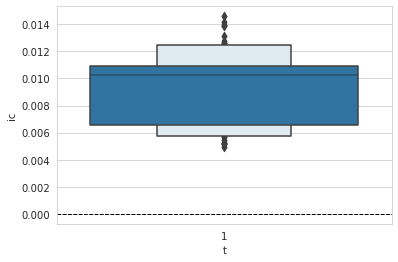

time: 178 ms (started: 2021-04-28 03:43:41 +00:00)


In [57]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

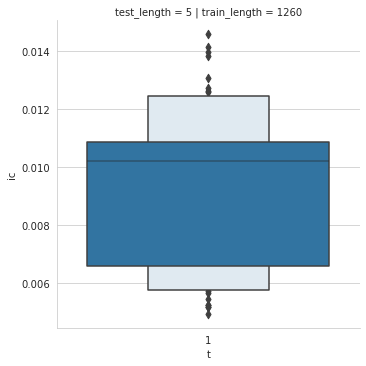

time: 439 ms (started: 2021-04-28 03:46:01 +00:00)


In [64]:
test_length = 5
#test_length = 21
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == test_length)],
                kind='boxen')
g.savefig(path_result / f'daily_ic_test_{test_length:02}', dpi=300);

### HyperParameter Impact: Linear Regression

To get a better idea of how the various CV parameters impact the forecast quality, we can run a linear regression with the daily IC as outcome and the one-hot encoded hyperparameters as inputs:

In [66]:
lin_reg = {}
#for t in [1, 5]:
for t in [1]:
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err',
                     't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(path_result / f'lr_result_{t:02}.csv', index=False)

time: 32.9 ms (started: 2021-04-28 03:47:07 +00:00)


In [67]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith(
        'date') & (coefs.variable != 'const')]
    #coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, 
               color='none', capsize=3, yerr='error', legend=False, rot=0)    
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

time: 1.04 ms (started: 2021-04-28 03:47:09 +00:00)


The below plot shows the regression coefficient values and their confidence intervals. The intercept (not shown) has a small positive value and is statistically signifant; it captures the impact of the dropped categories (the smallest value for each parameter).

For 1-day forecasts, some but not all results are insightful: 21-day testing is better, and so is `min_samples_leaf` of 500 or 1,000. 100-200 trees seem to work best, but both shorter and longer training periods are better than intermediate values.

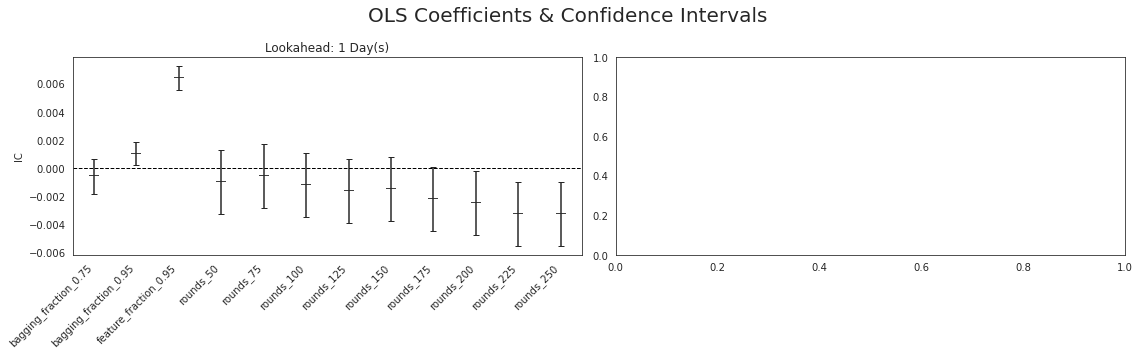

time: 500 ms (started: 2021-04-28 03:51:42 +00:00)


In [75]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    axes = axes.flatten()
    for i, t in enumerate([1, 5]):
    #for i, t in enumerate([1]): # testing
        visualize_lr_result(lin_reg[t], axes[i])
        axes[i].set_title(f'Lookahead: {t} Day(s)')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45, ha="right")
    fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.84)

### Information Coefficient: Overall

We'll also take a look at the overall IC value, which is often reported but does not necessarily match the goal of a daily trading strategy that uses the model return predictions as well as the daily IC.

In [76]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      60 non-null     int64  
 1   test_length       60 non-null     int64  
 2   bagging_fraction  60 non-null     float64
 3   feature_fraction  60 non-null     float64
 4   min_data_in_leaf  60 non-null     int64  
 5   t                 60 non-null     int64  
 6   rounds            60 non-null     int64  
 7   ic                60 non-null     float64
dtypes: float64(3), int64(5)
memory usage: 3.9 KB
time: 11.5 ms (started: 2021-04-28 03:52:16 +00:00)


#### Best Parameters

Directionally, and for shorter periods, similar hyperparameter settings work best (while the IC values are higher):

In [77]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                     
1 9           1260            5              0.95              0.75   
  6           1260            5              0.95              0.75   
  12          1260            5              0.95              0.75   

      min_data_in_leaf  t  rounds        ic  
t                                            
1 9               1000  1     100 -0.030860  
  6               1000  1      75 -0.033399  
  12              1000  1     125 -0.033868

time: 21.3 ms (started: 2021-04-28 03:52:19 +00:00)


#### Visualiztion

In [78]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 21) & (ic.t < 21)],
                kind='box')

ValueError: min() arg is an empty sequence

time: 20.8 ms (started: 2021-04-28 03:52:23 +00:00)


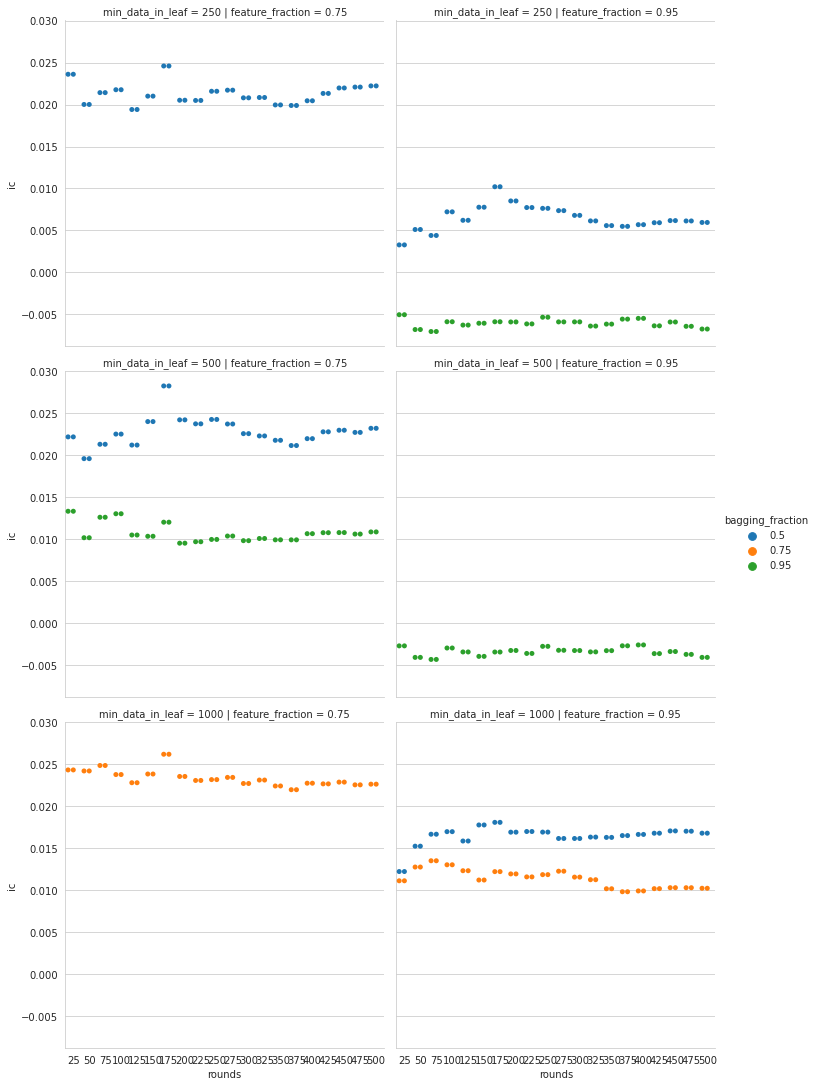

time: 10.9 s (started: 2021-04-27 06:38:26 +00:00)


In [24]:
t = 1
train_length = 756
test_length = 21
g = sns.catplot(x='rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=ic[(ic.t == t) &
            (ic.train_length == train_length) &
            (ic.test_length == test_length)],
    kind='swarm');

### Random Forest vs Linear Regression 

Let's compare the best-performing (in-sample) random forest models to our linear regression baseline:

In [79]:
lr_metrics = pd.read_csv(path_result / 'lin_reg_performance.csv')
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB
time: 18.6 ms (started: 2021-04-28 03:52:49 +00:00)


In [80]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 60 non-null     int64  
 1   train_length      60 non-null     int64  
 2   test_length       60 non-null     int64  
 3   bagging_fraction  60 non-null     float64
 4   feature_fraction  60 non-null     float64
 5   min_data_in_leaf  60 non-null     int64  
 6   rounds            60 non-null     int64  
 7   ic                60 non-null     float64
dtypes: float64(3), int64(5)
memory usage: 3.9 KB
time: 10.3 ms (started: 2021-04-28 03:52:51 +00:00)


The results are mixed: for the shortest and longest horizons, the random forest outperforms (slightly for 1 day), while linear regression is competitive for the intermediate horizons:

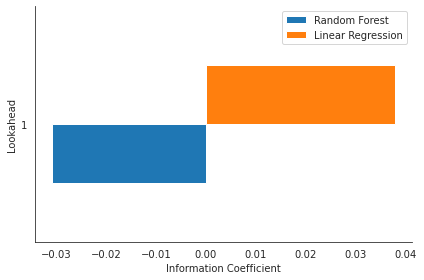

time: 430 ms (started: 2021-04-28 03:52:53 +00:00)


In [81]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();

## Generate predictions

To build and evaluate a trading strategy, we create predictions for the 2017-19 period using the 10 best models that we then ensemble:

In [54]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

Copying gs://finance_data_bucket/data_stooq.zip...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][651.8 MiB/651.8 MiB]                                                
Operation completed over 1 objects/651.8 MiB.                                    
Archive:  data_stooq.zip
  inflating: data/stooq_jp_tse_stocks_prices.csv  
  inflating: data/stooq_jp_tse_stocks_tickers.csv  
  inflating: data/stooq_us_nasdaq_etfs_prices.csv  
  inflating: data/stooq_us_nasdaq_etfs_tickers.csv  
  inflating: data/stooq_us_nasdaq_stocks_prices.csv  
  inflating: data/stooq_us_nasdaq_stocks_tickers.csv  
  inflating: data/stooq_us_nyse_etfs_prices.csv  
  inflating: data/stooq_us_nyse_etfs_tickers.csv  
  inflating: data/stooq_us_nyse_stocks_prices.csv  
  inflating: data/stooq_us_nyse_st

In [82]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

time: 477 µs (started: 2021-04-28 03:53:45 +00:00)


In [83]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

time: 672 µs (started: 2021-04-28 03:53:46 +00:00)


In [84]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 4
time: 1.22 ms (started: 2021-04-28 03:53:49 +00:00)


In [103]:
num_models = 10
#num_models = 1 # testing

for lookahead in [1, 5, 10, 21]:
    if lookahead > 1: 
        continue
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_csv(path_data / 'stooq_jp_equities.csv', parse_dates=['date'])
              .set_index(['ticker','date'])
              .sort_index(level=['ticker','date'])
              .loc[idx[:, '2010': '2019'], :]
              )
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(num_models):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = int(val_length / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        #params=params).construct()
                                        params=params)
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              categorical_feature=categoricals, 
                              verbose_eval=False)
        
            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        

    by_day = test_predictions.groupby(level='date')
    for position in range(num_models):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])

    test_predictions.to_csv(path_result / f'test_{lookahead:02}.csv')


Lookahead: 01
	Position: 00
time: 5min 15s (started: 2021-04-28 04:44:28 +00:00)


In [36]:
!zip -u stooq_jp_result.zip result/test_01.csv

  adding: result/test_01.csv (deflated 64%)
time: 10.2 s (started: 2021-04-27 07:27:07 +00:00)


In [104]:
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 235250 entries, ('1332.JP', Timestamp('2019-12-23 00:00:00')) to ('9990.JP', Timestamp('2018-12-20 00:00:00'))
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  235250 non-null  float64
 1   0       235250 non-null  float64
dtypes: float64(2)
memory usage: 4.5+ MB
time: 15.2 ms (started: 2021-04-28 04:57:13 +00:00)


In [105]:
test_predictions.head()

y_test         0
ticker  date                          
1332.JP 2019-12-23  0.018612  0.000727
        2019-12-24 -0.013696  0.000655
        2019-12-25  0.009247  0.000730
        2019-12-26  0.001538  0.000668
        2019-12-27 -0.004590  0.001380

time: 9.22 ms (started: 2021-04-28 04:57:18 +00:00)
